# Wind Power Predition

<img src="https://hornsdalewindfarm.com.au/wp-content/uploads/2017/07/hornsdale-wind-farm.jpg" style=" width: 600px; ">
<i><font size=1.5><center>Picture from hornsdalewindfarm.com.au</center></font></i>

_Authors: Heng Wang_

# Introduction
Wind power is currently one of the lowest-cost sources of new electricity supply in Australia that generates enough electricity to meet 7.1% of the nation’s total electricity demand. However, the generation of wind power is un-dispatchable, making it difficult to integrate wind into the existing power grid. A forecast system can help the power grid to react better to the electricity dispatch, as well as improve energy trading profit for business investors. 

Forecasts are divided into short- (minutes), medium- (up to 48 hours) and long-term (up to 1 week). Based on the frequency of the available dataset and current machine learning capability, the medium-term forecast is of the most interest. In this notebook, a framework of a forecast system for individual wind farm is explored using neural network and XGBoost.

# Obtain data

Data will be obtained from publicly available sources. The overall flow is as follows:

First, the info of all major wind farms is obtained from an API provided by the Australian Renewable Energy Mapping Infrastructure Project (AREMI) and stored in `farms`. This gives an overview of all info (e.g., the location of the farm, current output) which will be used later.
For a specific `farm`, the power data from Jun 2019 to Feb 2020 is obtained through another AREMI API in 5 min interval. A reference datatime dataframe is merged with the data to ensure no missing point in time. After filling potential missing values, the power data is converted to a 1-hour interval format by averaging all data within the hour. Hourly weather data is obtained through an API provided by Dark Sky given the latitude and longitude of the farm and is combined with the power data.

In [447]:
import pandas as pd
import numpy as np
import datetime,pytz
import urllib.request, json
import warnings
warnings.simplefilter("ignore", DeprecationWarning)
warnings.simplefilter("ignore", FutureWarning, )
pd.options.mode.chained_assignment = None 

In [369]:
farms = pd.read_csv('https://services.aremi.data61.io/aemo/v6/csv/wind')
farms.set_index('DUID',inplace=True)
farms.head()

,Station Name,Current Output (MW),Region,Most Recent Output Time (AEST),Current % of Max Cap,Current % of Reg Cap,Max Cap (MW),Reg Cap (MW),Max ROC/Min,Unit Size (MW),...,Dispatch Type,Category,Classification,Fuel Source - Primary,Fuel Source - Descriptor,Technology Type - Primary,Technology Type - Descriptor,Aggregation,Lat,Lon
DUID,,,,,,,,,,,,,,,,,,,,,
ARFW1,Ararat Wind Farm,NaN,VIC1,NaN,NaN,NaN,241.59,241.59,50.0,12.26,...,Generator,Market,Semi-Scheduled,Wind,Wind,Renewable,Wind - Onshore,Y,-37.238181,143.052044
BALDHWF1,Bald Hills Wind Farm,8.944,VIC1,2020-03-11T23:35:00+0000,7.45,8.39,120.00,106.60,NaN,106.6,...,Generator,Market,Semi-Scheduled,Wind,Wind,Renewable,Wind - Onshore,N,-38.790800,145.927700
BLUFF1,The Bluff Wind Farm,42.600,SA1,2020-03-11T23:35:00+0000,81.14,81.14,52.50,52.50,30.0,2.1,...,Generator,Market,Semi-Scheduled,Wind,Wind,Renewable,Wind - Onshore,N,-33.369331,138.982476
BOCORWF1,Boco Rock Wind Farm,34.070,NSW1,2020-03-11T23:35:00+0000,30.10,30.10,113.18,113.18,201.0,"1.7, 1.62",...,Generator,Market,Semi-Scheduled,Wind,Wind,Renewable,Wind - Onshore,N,-36.591414,149.129675
CAPTL_WF,Capital Wind Farm,0.000,NSW1,2020-03-11T23:35:00+0000,0.00,0.00,140.00,140.00,NaN,2,...,Generator,Market,Non-Scheduled,Wind,Wind,Renewable,Wind - Onshore,N,-35.166031,149.518569


## Define helper functions

### Functions to handle time data

In [2]:
def get_tz(farm):
    '''
    Get timezone for speific farm, based on the location found in the AEMO farm table
    Output a string
    '''
    if farms.loc[farm,'Region'] == 'SA1':
        return 'Australia/Adelaide'
    elif farms.loc[farm,'Region'] == 'NSW1':
        return 'Australia/Sydney'
    elif farms.loc[farm,'Region'] == 'VIC1':
        return 'Australia/Melbourne'
    elif farms.loc[farm,'Region'] == 'TAS1':
        return 'Australia/Hobart'
    elif farms.loc[farm,'Region'] == 'QLD1':
        return 'Australia/Brisbane'

In [3]:
def unix_2_utc(time):
    '''
    Convert unix time to a readable time format in UTC
    Input time should be string or int of UNIX time
    Output is a string in the format of %Y-%m-%d %H:%M:%S
    '''
    utc_dt = datetime.datetime.utcfromtimestamp(int(time)).replace(tzinfo=pytz.utc)
    return utc_dt.strftime('%Y-%m-%d %H:%M:%S')

In [4]:
def str_2_utc(time):
    '''
    Convert the ISO format to time format in UTC
    Input time should be string 
    Output is a string in the format of %Y-%m-%d %H:%M:%S
    '''
    utc_dt = datetime.datetime.fromisoformat(time[:19])
    return utc_dt.strftime('%Y-%m-%d %H:%M:%S')

In [5]:
def utc_2_local(time,tz):
    '''
    Convert UTC time to local time in timezone tz
    Input time should be string in the format of %Y-%m-%d %H:%M:%S
    Input tz should be string (e.g., 'Australia/Brisbane')
    Output is a string in the format of %Y-%m-%d %H:%M:%S
    '''
    tz = pytz.timezone (tz)
    time = datetime.datetime.strptime (time, "%Y-%m-%d %H:%M:%S")
    local_dt = pytz.utc.localize(time).astimezone(tz)
    return local_dt.strftime('%Y-%m-%d %H:%M:%S')

In [6]:
def local_2_utc(time,tz,is_dst=False):
    '''
    Convert local time in timezone tz to UTC time
    Input time should be string in the format of %Y-%m-%d %H:%M:%S
    Input tz should be a string (e.g., 'Australia/Brisbane')
    Output is a string in the format of %Y-%m-%d %H:%M:%S
    '''
    local = pytz.timezone (tz)
    naive = datetime.datetime.strptime(time, "%Y-%m-%d %H:%M:%S")
    local_dt = local.localize(naive, is_dst=False)
    utc_dt = local_dt.astimezone(pytz.utc)
    return utc_dt.strftime ("%Y-%m-%d %H:%M:%S")

### Functions to get and clean data

In [7]:
def fill_val(df,offset):
    '''
    Fill missing value with the mean of the -24h and +24h data
    offset is the rows for the +24h/-24h, for 1h interval is 24, for 5min interval is 288
    '''
    for item in df.drop('time',axis=1).columns:
        for i in df[df.isna().any(1)].index:
            try:
                v_plus = df[item][i+offset]
            except:
                v_plus = np.nan
            try:
                v_minus = df[item][i-offset]
            except:
                v_minus = np.nan
            
            if not pd.isnull(v_plus) and not pd.isnull(v_minus):
                v = 0.5 * (v_plus + v_minus)
            elif pd.isnull(v_plus):
                v = v_minus
            elif pd.isnull(v_minus):
                v = v_plus
            else:
                v = np.nan
            
            df.loc[i,item] = v

In [8]:
def get_ref_dt_range(df,utc_start_dt,utc_end_dt,freq):
    '''
    Get a reference data range df given utc_start_dt, utc_end_dt, freq and merge it to original df
    This ensures df have no missing datatime range
    Missing values will show up as NaN, which can be filled later
    utc_start_dt,utc_end_dt are strings in the format of %Y-%m-%d %H:%M:%S
    freq is a string that speficy frequency(e.g., 5Min,1H)
    output if the df with no missing point in timeseries
    '''
    ref_dt_range = pd.date_range(utc_start_dt,utc_end_dt,freq=freq)
    ref_dt_range = pd.DataFrame(ref_dt_range,columns=['time'])
    ref_dt_range['time'] = ref_dt_range['time'].apply(str)
    df = pd.merge(df,ref_dt_range,left_on='time',right_on='time',how='outer',sort=True)
    
    return df

In [9]:
def get_power(farm,local_start_dt,local_end_dt,offset):
    '''
    Get the power data given farm and time period
    farm is a string corresponds to the DUID in the farms dataframe
    local_start_dt,local_end_dt are strings in the format of %Y-%m-%d %H:%M:%S
    offset if a string corresponds to how far away from current time
    return a dataframe with power output in 5min interval, with no gap in time series or missing value 
    
    '''
    # Get basic info
    tz = get_tz(farm)
    utc_start_dt = local_2_utc(local_start_dt,tz)
    utc_end_dt = local_2_utc(local_end_dt,tz)

    # The api only returns data from the offset time to current time. Offset value should be estimated properly.
    # Usually a larger window is choosen, which is sliced to desired dt window later.
    power_api = 'https://services.aremi.data61.io/aemo/v6/duidcsv/'+farm+'?offset='+offset
    power = pd.read_csv(power_api)

    # Conver the time format
    power['time'] = power['Time (UTC)'].apply(str_2_utc)
    power.drop(['Time (UTC)'],axis = 1, inplace=True)

    # Get the row of the start date and end date, slice the df to desired dt range
    start_index = 0
    if power['time'][0] > utc_start_dt:
        pass # in case utc_start_time is after the data start time
    else:
        while not (utc_start_dt in str(power['time'][start_index])):
            start_index += 1            
    
    end_index = len(power) -1 # search from bottom to top for better performance
    while not (utc_end_dt in str(power['time'][end_index])):
        end_index -= 1
    power = power[start_index:end_index]    

    # Join the reference dt range. If there's missing time points the row will show as NaN.
    power = get_ref_dt_range(power,utc_start_dt,utc_end_dt,'5Min')
    power.drop_duplicates(subset='time', keep='first', inplace=True)
    power.reset_index(drop=True,inplace=True)

    # Fill missing value, if any
    fill_val(power,288)
    
    # Set negative values to 0, if any
    for i in power[power['MW'] < 0].index:
        power.loc[i,'MW'] = 0
        
    return power

In [10]:
def get_power1h(power):
    '''
    Converts power output in 5min interval to 1h interval
    '''
    # Init a power1h df, the power is the mean of the power recorded within the hour.
    power1h = pd.DataFrame()
    for i in range(len(power)//12):
        power1h.loc[i, 'time'] = power[i*12:(i+1)*12]['time'][i*12]
        power1h.loc[i, 'power'] = power[i*12:(i+1)*12]['MW'].mean()
    
    return power1h

In [11]:
def get_weather_ds(farm,local_start_dt,local_end_dt):
    '''
    Get the raw actual weather data from Darksky, given the farm and time period
    farm is a string corresponds to the DUID in the farms dataframe
    local_start_dt,local_end_dt are strings in the format of %Y-%m-%d %H:%M:%S
    returns dataframe is hourly weather data 
    
    '''
    # Basic info
    dakrskykey = '' # provided by DarkSky, you can get your key on darksky.net/dev for free
    location = str(round(farms.loc[farm,'Lat'],6))+','+str(round(farms.loc[farm,'Lon'],6))
    flags = '?exclude=currently,daily,flags&units=si'

    # Set a dt range, call the api for each day's data in the dt range
    local_dt_range = pd.date_range(local_start_dt, local_end_dt, freq = '1D')

    weather = pd.DataFrame()
    
    for dt in local_dt_range[:-1]:
        # Construct the api url for each day
        time = dt.strftime("%Y-%m-%d")+'T00:00:00'
        dsapi = 'https://api.darksky.net/forecast/'+dakrskykey+'/'+location+','+time+flags

        # Load the json from api and turns to df, attach each day's df to the master weather df
        with urllib.request.urlopen(dsapi) as url:
            data = json.loads(url.read().decode())     
        try:
            df = pd.DataFrame(data['hourly']['data'])
        except:
            df = pd.DataFrame()
        weather = pd.concat([weather,df],axis = 0,sort=True)

    weather['time'] = weather['time'].apply(unix_2_utc)       
    weather = weather[['time', 'icon', 'cloudCover', 'dewPoint', 'humidity', 'ozone', 'precipIntensity', 'pressure',  
     'temperature',  'uvIndex', 'visibility', 'windBearing', 'windGust', 'windSpeed']]
    
    # make sure there's no missing point in time series
    weather = get_ref_dt_range(weather,weather.iloc[0,0],weather.iloc[-1,0],'1H')
    weather.drop_duplicates(subset='time', keep='first', inplace=True)
    weather.reset_index(drop=True,inplace=True)
    
    return weather

In [12]:
def combine_df(weather,power1h):    
    '''
    Combine weather and power1h data, if there's missing points in time for weather if will be filled;
    returns a cleaned dataframe with hourly weather and power output data 
    '''
    df = pd.merge(weather,power1h,left_on='time',right_on='time',how='outer',sort=True)
       
    # Fill missing values
    fill_val(df,24)

    return df

## Getting the data
Get the data for a specific `farm` given the datetime range. Hornsdale Wind Farm Stages 2 (DUID HDWF2) will be used as an example throughout this notebook.

In [91]:
farm = 'HDWF2'
# local_start_dt = "2017-07-01 00:00:00" #local
# local_end_dt = "2020-02-01 00:00:00" #local
# tz = get_tz(farm)

# weather = get_weather_wwo(farm,local_start_dt,local_end_dt,tz)
# power = get_power(farm,local_start_dt,local_end_dt,'40M')
# power1h = get_power1h(power)
# df = combine_df(weather,power1h)
# df.to_csv('./datasets/raw_'+farm+'.csv',index=False)

# Data pre-processing

## EDA
The distribution of each numeric columns are plotted below. `precipIntensity`, `uvIndex`, and `visibility` are heavily skewed and may not be useful for modelling, thus they are dropped. Other than that, the data itself is rather clean, with no obvious error values nor missing values. 

In [370]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 12, 4
plt.rcParams['font.size'] = 14

In [93]:
df = pd.read_csv('./datasets/DS_'+farm+'.csv')

In [94]:
# check if there's still missing values
df[df.isna().any(1)]

,time,icon,cloudCover,dewPoint,humidity,ozone,precipIntensity,pressure,temperature,uvIndex,visibility,windBearing,windGust,windSpeed,power


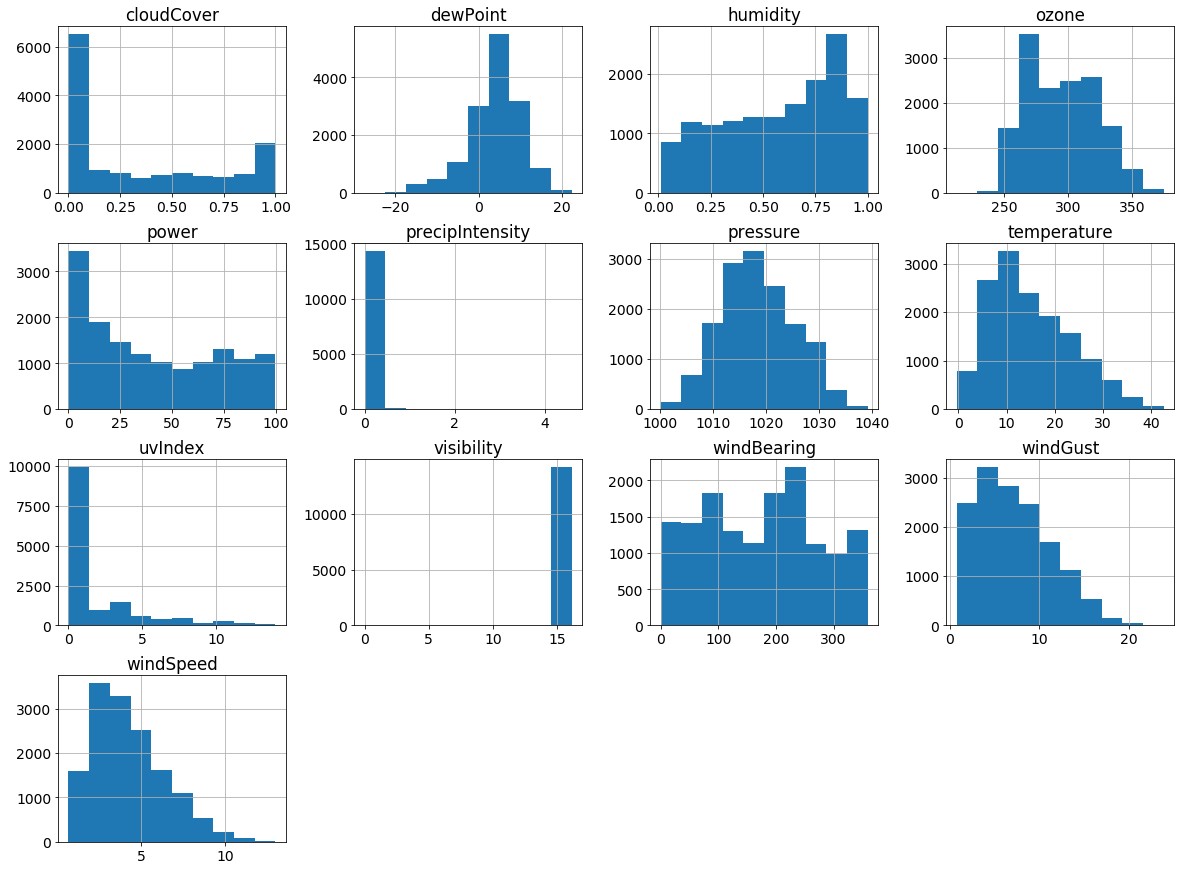

In [95]:
df.hist(figsize=(20,15));

From below heatmap, both `windSpeed` and `windGust` strongly correlate to `power`, which is well-expected. Other weather features show rather weak correlation.

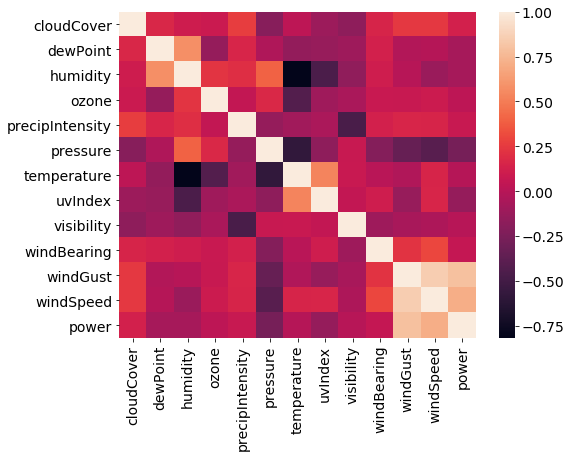

In [96]:
import seaborn as sns
plt.figure(figsize=(8,6))
sns.heatmap(df.corr())

In [97]:
df.drop(['precipIntensity','visibility','uvIndex'],axis=1,inplace=True)

Further, `windBearing` is a rotatin data that potentially causes issue. It is converted to sine and cosine values.

In [101]:
df['windSin'] = np.sin(df.windBearing * np.pi / 180.)
df['windCos'] = np.cos(df.windBearing * np.pi / 180.)

In [102]:
df.drop(['windBearing'],axis=1,inplace=True)

## Feature engineering

The ideal wind power generation is described by the following formula:
\begin{equation*}
P = \frac{1}{2} \rho S c_p W_s^3
\end{equation*}

where $P$ is the power output, $\rho$ is the density of the air, $S$ is the rotor surface, $c_{p}$ is the power coefficient, and $W_{s}$ is the speed of the wind. It is then worth considering to include the higher power of `windSpeed` and `windGust` as features, as well as air density. Density is calculated through temperature, pressure, and dew point/humidity in `cal_density`.


In [103]:
def cal_density(T,P,Td):
    '''
    Calcuate the air density rho (kg/m^3) given temperature T 
    (Celsius C), Pressure P(hPa) and dew point (Celsius C)
    Ref: https://www.gribble.org/cycling/air_density.html
    '''

    eso = 6.1078
    c0 = 0.99999683
    c1 = -0.90826951E-2
    c2 = 0.78736169E-4
    c3 = -0.61117958E-6
    c4 = 0.43884187E-8
    c5 = -0.29883885E-10
    c6 = 0.21874425E-12
    c7 = -0.17892321E-14
    c8 = 0.11112018E-16
    c9 = -0.30994571E-19
    p = c0 + Td *(c1 + Td *(c2 + Td *(c3 + Td *(c4 + \
        Td *(c5 + Td *(c6 + Td *(c7 + Td *(c8 + Td *(c9)))))))))
    Pv = eso / p**8
    
    Pd  = P - Pv
    Tk = T + 273.15
    
    Rv = 461.4964
    Rd = 287.0531
    
    rho = ((Pd / (Rd * Tk)) + (Pv / (Rv * Tk)))*100
    
    return rho

In [104]:
df['windSpeed2'] = df['windSpeed']**2
df['windSpeed3'] = df['windSpeed']**3
df['windGust2'] = df['windGust']**2
df['windGust3'] = df['windGust']**3

In [105]:
df['density'] = cal_density(df.temperature,df.pressure,df.dewPoint)

In [106]:
import seaborn as sns

In [107]:
df.corr()[['power']].T

,cloudCover,dewPoint,humidity,ozone,pressure,temperature,windGust,windSpeed,power,windSin,windCos,windSpeed2,windSpeed3,windGust2,windGust3,density
power,0.13093,-0.069395,-0.067861,0.032488,-0.269698,-0.001476,0.79546,0.714116,1.0,-0.08138,0.175791,0.656066,0.573789,0.726931,0.625631,-0.054549


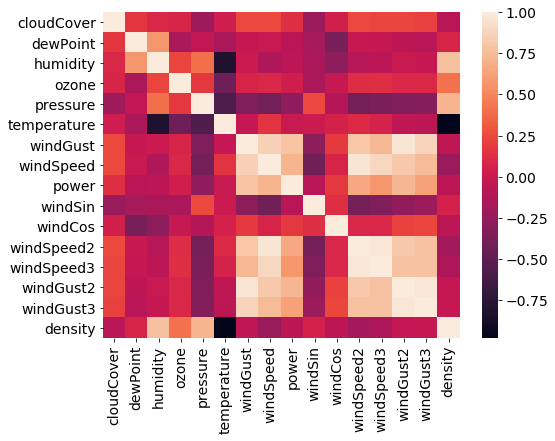

In [108]:
import seaborn as sns
plt.figure(figsize=(8,6))
sns.heatmap(df.corr())

The created wind features show great correlation with power. `density` doesn't correlate well with `power`, but it strongly correlates with `humidity`,`pressure`, and `temperature`, and `humidity` itself is correlated to `dewPoint`. This possibly means the highly-correlated features `humidity`,`pressure`, `temperature` and `dewPoint` can be replaced by `density`, which is a known factor that affects wind power production.

### Feature selection
For select desired features, XGBoost is used, as this will be the main model in this notebook.

In [110]:
X = df.drop(['time','icon','power'],axis=1)
y = df['power']

In [111]:
train_size = int(len(df) * 0.9)
test_size = len(df) - train_size
X_train, X_test = X.iloc[0:train_size], X.iloc[train_size:len(df)]
y_train, y_test = y.iloc[0:train_size].values, y.iloc[train_size:len(df)].values

In [112]:
from sklearn.preprocessing import RobustScaler
ss = RobustScaler()
Xs_train = ss.fit_transform(X_train)
Xs_test = ss.transform(X_test)

In [113]:
X.head()

,cloudCover,dewPoint,humidity,ozone,pressure,temperature,windGust,windSpeed,windSin,windCos,windSpeed2,windSpeed3,windGust2,windGust3,density
0,0.50,8.83,0.66,284.9,1024.7,15.05,3.82,3.17,-0.529919,-0.848048,10.0489,31.855013,14.5924,55.742968,1.233444
1,0.54,8.77,0.67,285.2,1024.5,14.88,3.84,3.45,-0.515038,-0.857167,11.9025,41.063625,14.7456,56.623104,1.233951
2,0.61,8.58,0.70,284.9,1024.4,14.04,3.98,3.85,-0.484810,-0.874620,14.8225,57.066625,15.8404,63.044792,1.237505
3,0.72,8.38,0.74,284.3,1024.7,12.89,4.18,3.88,-0.422618,-0.906308,15.0544,58.411072,17.4724,73.034632,1.242915
4,0.83,8.18,0.80,284.8,1025.4,11.57,4.29,3.44,-0.390731,-0.920505,11.8336,40.707584,18.4041,78.953589,1.249603


In [118]:
import xgboost as xgb
xgb_fs=xgb.XGBRegressor(max_depth=3, colsample_bytree=0.7, learning_rate=0.100, n_estimators=100, min_child_weight=4)
xgb_fs.fit(Xs_train, y_train,verbose=False);

In [119]:
xgbcoef_fs = pd.DataFrame({'feature':X.columns, 
                           'importance': xgb_fs.feature_importances_*100})
xgbcoef_fs[xgbcoef_fs.importance>=0].sort_values(by='importance',ascending=False).T

,13,12,6,11,7,8,10,2,9,14,5,0,1,4,3
feature,windGust3,windGust2,windGust,windSpeed3,windSpeed,windSin,windSpeed2,humidity,windCos,density,temperature,cloudCover,dewPoint,pressure,ozone
importance,40.3016,27.8991,17.0324,3.67802,2.43308,2.27659,2.12513,1.25563,0.696517,0.427509,0.427188,0.420891,0.402906,0.341641,0.281779


All features except for wind related features have a rather weak contribution. `humidity` with the highest importance after the wind features is kept, as well as `density`, because can be seen as a combination of other all the remaining highly-correlated features.

In [120]:
df = df[['time', 'humidity', 'density', 'windSin', 'windCos', 'windGust', 'windGust2', 
         'windGust3', 'windSpeed', 'windSpeed2', 'windSpeed3', 'power']]

In [121]:
df.head(2)

,time,humidity,density,windSin,windCos,windGust,windGust2,windGust3,windSpeed,windSpeed2,windSpeed3,power
0,4/06/2018 03:30,0.66,1.233444,-0.529919,-0.848048,3.82,14.5924,55.742968,3.17,10.0489,31.855013,6.625000
1,4/06/2018 04:30,0.67,1.233951,-0.515038,-0.857167,3.84,14.7456,56.623104,3.45,11.9025,41.063625,10.633333


In [122]:
# df.to_csv('./datasets/processed_'+farm+'.csv',index=False)

# Modelling

## Time series models

### ARIMA time series

A simple ARIMA model is first employed on the power data only. (p,d,q) values are chosen via ACF, PACF and stationarity test. 

In [372]:
df = pd.read_csv('./datasets/Processed'+farm+'.csv')

In [373]:
# Baseline RMSE, use a persistence model/navie forecast
print('Baseline RMSE: '+str(mse(df.power.drop(0),df.power.shift().dropna(),squared=False)))

Baseline RMSE: 11.373706676848267


In [374]:
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(df.power)
print('ADF Statistic: %f' % adf_result[0])
print('p-value: %f' % adf_result[1])
print('Critical Values:')
for key, value in adf_result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -16.830812
p-value: 0.000000
Critical Values:
	10%: -2.567
	5%: -2.862
	1%: -3.431


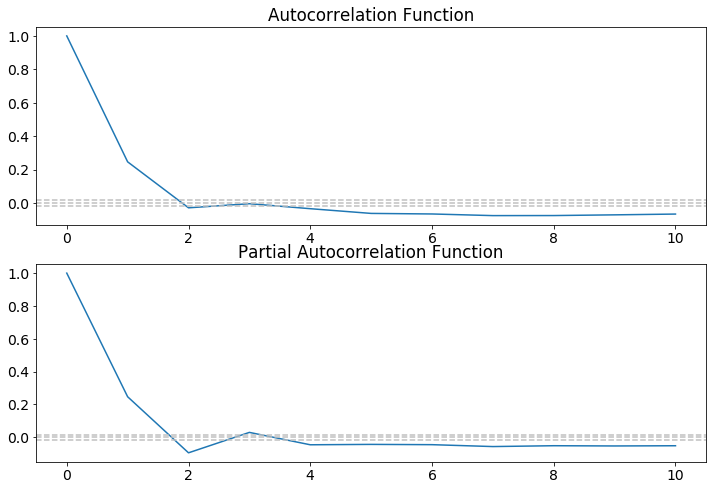

In [375]:
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf

acf_lag = acf(df.power.diff().dropna().values, nlags=10)
pacf_lag = pacf(df.power.diff().dropna().values, nlags=10, method='ols')

plt.figure(figsize=(12,8))

plt.subplot(211)
plt.plot(acf_lag)
plt.axhline(y=0,linestyle='--',color='silver')
plt.axhline(y=-1.96/np.sqrt(len(df.power.diff().values)),linestyle='--',color='silver')
plt.axhline(y=1.96/np.sqrt(len(df.power.diff().values)),linestyle='--',color='silver')
plt.title("Autocorrelation Function")

plt.subplot(212)
plt.plot(pacf_lag)
plt.axhline(y=0,linestyle='--',color='silver')
plt.axhline(y=-1.96/np.sqrt(len(df.power.diff().values)),linestyle='--',color='silver')
plt.axhline(y=1.96/np.sqrt(len(df.power.diff().values)),linestyle='--',color='silver')
plt.title("Partial Autocorrelation Function");

RMSE:10.686415298747642


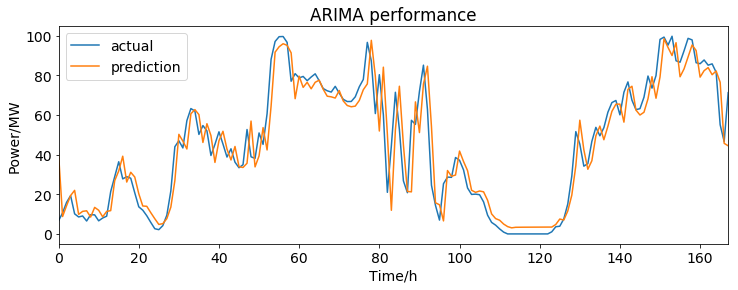

In [376]:
from statsmodels.tsa.arima_model import ARIMA
arima = ARIMA(df.power, order=(2,0,2))
arima_result = arima.fit()

arima_pred=pd.DataFrame()
arima_pred['actual'] = df.power
arima_pred['prediction'] = arima_result.predict()
arima_pred[:168].plot(title='ARIMA performance')
plt.ylabel("Power/MW")
plt.xlabel("Time/h");
print('RMSE:'+ str(mse(arima_pred['actual'],arima_pred['prediction'],squared=False)))

### LSTM time series
ARIMA and other similar MA models will do poorly for medium- and long-term forecast, which is undesirable for this use case. An LSTM model can be a better choice for medium- or even long term forecast. It is also easier to incorporate external regressors like weather data. A simple Bidirectional LSTM is used here. It will take the previous `time_steps` number of data and predict the number of `pred_steps` ahead. The output is a vector containing `pred_steps` number of predictions. The `y_pred_steps`-th element of each vector can be used to evaluate the performance of `y_pred_steps` ahead prediction. The topology and hyperparameters of the models are preliminarily tuned.

In [222]:
df = pd.read_csv('./datasets/Processed'+farm+'.csv')
df.drop(['time'],axis=1,inplace=True) 

In [213]:
def create_dataset(X, time_steps): 
    '''
    Helper function to create 3D data with in the shape of [samples, time_steps, features] for LSTM
    '''
    Xs, ys = [], []
    for i in range(len(X) - time_steps-pred_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(X.power.iloc[i+time_steps:i+time_steps+pred_steps].astype('float64').values)
    return np.array(Xs), np.asarray(ys)

In [214]:
time_steps = 3
pred_steps = 24

In [215]:
# Split to train & test (ratio 0.9), keep the order of the series
train_size = int(len(df) * 0.9)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]

# Scale both X and y using RobustScaler, which deals better with outliners
from sklearn.preprocessing import RobustScaler

X_columns = ['humidity', 'density', 'windSin', 'windCos', 'windGust',
       'windGust2', 'windGust3', 'windSpeed', 'windSpeed2', 'windSpeed3']
X_scale = RobustScaler().fit(train[X_columns])
y_scale = RobustScaler().fit(train[['power']])

train.loc[:, X_columns] = X_scale.transform(train[X_columns])
train['power'] = y_scale.transform(train[['power']])
test.loc[:, X_columns] = X_scale.transform(test[X_columns])
test['power'] = y_scale.transform(test[['power']])

X_train, y_train = create_dataset(train, time_steps)
X_test, y_test = create_dataset(test, time_steps)

In [216]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Bidirectional, LSTM, Dropout, Input, GRU 
from sklearn.metrics import mean_squared_error as mse

In [217]:
inputs=Input(shape=(X_train.shape[1], X_train.shape[2]))
x=Bidirectional(LSTM(128))(inputs)
x=Dropout(rate=0.3)(x)
outputs=Dense(pred_steps)(x)

lstm=Model(inputs=inputs, outputs=outputs)

In [218]:
%%time
reduceLR = keras.callbacks.ReduceLROnPlateau(monitor='lr', factor=0.2, patience=5, min_lr=0.0001, verbose=0)
earlyStop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
lstm.compile(loss='mse', optimizer=tf.optimizers.Nadam(learning_rate=0.01))
history = lstm.fit(X_train, y_train, epochs=150, callbacks=[earlyStop,reduceLR], batch_size=32, validation_split=0.1, shuffle=False, verbose=0)

CPU times: user 2min 12s, sys: 29.1 s, total: 2min 41s
Wall time: 1min 19s


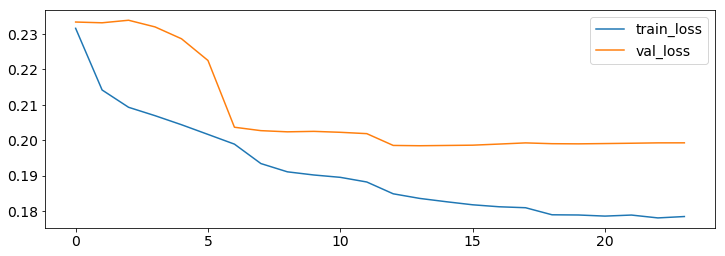

In [219]:
# Plot out the loss values over epoch
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

RMSE:11.288690766786795


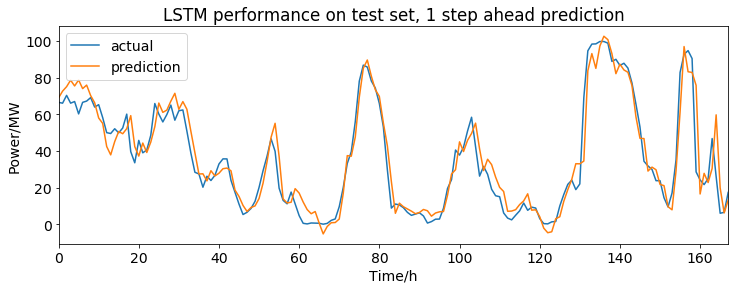

In [220]:
y_pred_steps = 1 # Show which ys in the multiple step we're going to use
y_test_pred = lstm.predict(X_test)
y_test_inv = y_scale.inverse_transform(y_test.T[y_pred_steps-1].reshape(1, -1))
y_test_pred_inv = y_scale.inverse_transform(y_test_pred.T[y_pred_steps-1].reshape(1, -1))

lstm1_pred = pd.DataFrame()
lstm1_pred['actual'] = y_test_inv.reshape(y_test_inv.shape[1], )
lstm1_pred['prediction'] = y_test_pred_inv.reshape(y_test_pred_inv.shape[1], )
lstm1_pred[['actual','prediction']][:168].plot(title='LSTM performance on test set, 1 step ahead prediction')
plt.ylabel("Power/MW")
plt.xlabel("Time/h")
print('RMSE:'+ str(mse(lstm1_pred['actual'],lstm1_pred['prediction'],squared=False)))

RMSE:25.679788897620625


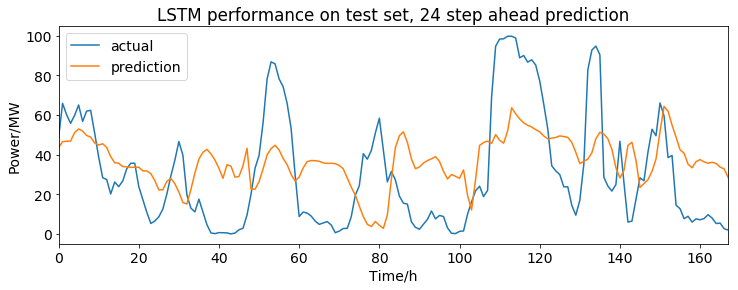

In [221]:
y_pred_steps = 24 # Show which ys in the multiple step we're going to use
y_test_pred = lstm.predict(X_test)
y_test_inv = y_scale.inverse_transform(y_test.T[y_pred_steps-1].reshape(1, -1))
y_test_pred_inv = y_scale.inverse_transform(y_test_pred.T[y_pred_steps-1].reshape(1, -1))

lstm24_pred = pd.DataFrame()
lstm24_pred['actual'] = y_test_inv.reshape(y_test_inv.shape[1], )[:-(y_pred_steps-1)]
lstm24_pred['prediction'] = y_test_pred_inv.reshape(y_test_pred_inv.shape[1], )[y_pred_steps-1:]
lstm24_pred[['actual','prediction']][:168].plot(title='LSTM performance on test set, 24 step ahead prediction')
plt.ylabel("Power/MW")
plt.xlabel("Time/h")
print('RMSE:'+ str(mse(lstm24_pred['actual'],lstm24_pred['prediction'],squared=False)))

Unfortunately, like ARIMA, the LSTM model seems to only learn to use the value at t-1 to predict the value at t. This suggests that the time series is a random walk, and the best way to predict it is to use the baseline persistent model. Indeed, both ARIMA and LSTM barely outperform the persistent model in terms of RMSE.
Furthermore, the 24 steps ahead prediction for LSTM is poor, which might not be surprising considering the model cannot learn the long-term trend of a random walk.


Finally, the 1 step ahead prediction performance for LSTM is slightly worse than ARIMA, which means it is also not extracting enough information from the weather data.


## Regression models
Considering the power output of a wind turbine is closely related to the weather, especially the wind condition, rather than the previous output in time. The problem can be re-framed as a regression problem, and the goal is to build a model to map out the correlation between weather condition and power.

To potentially improve the performance of the regression model, the power data is denoised and smoothed using a wavelet transform. Wavelet transform breaks down a series in both *frequency- and time-domain* into an Approximation part and a Detail part. The Detail part oscillates at a high frequency, which tends to be the noise in the signal. In this case, the Detail part is simply discarded.

In [382]:
df = pd.read_csv('./datasets/Processed'+farm+'.csv')

In [383]:
import pywt
cA1, cD1 = pywt.dwt(df.power, 'db4')
A1 = pywt.idwt(cA1,None, 'db4')
D1 = pywt.idwt(None,cD1, 'db4')

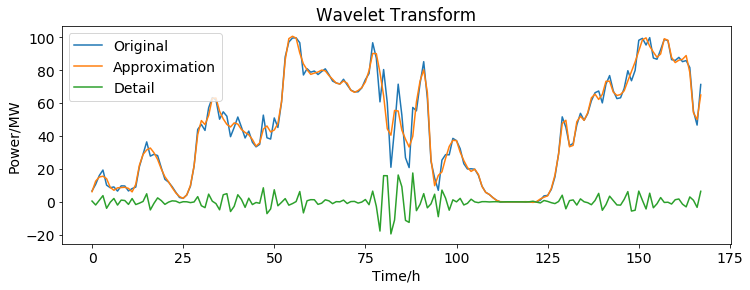

In [384]:
plt.plot(df['power'][:168],label='Original')
plt.plot(A1[:168],label='Approximation')
plt.plot(D1[:168],label='Detail')
plt.ylabel("Power/MW")
plt.xlabel("Time/h")
plt.title("Wavelet Transform")
plt.legend();

In [385]:
df['power'] = A1[:len(df)]
df.loc[df[df['power'] < 0].index,'power'] = 0

### XGBoost regression
XGBoost regression model is used because, as it does not assume linearity.

To accommodate for the time series nature of the data, time-related features such as an hour of the day are added to the via a one-hot encoder. Weather data is used as X to train the model. `early_stopping_rounds` and some l1-l2 regularization method is used to reduce overfitting. The hyperparameters of the models are preliminarily tuned.

In [386]:
df.time = pd.to_datetime(df.time,dayfirst=True)
df['hour'] = df['time'].dt.hour
df['month'] = df['time'].dt.month
df['year'] = df['time'].dt.year
df['dayofmonth'] = df['time'].dt.day

In [387]:
cat_col = ['hour', 'month', 'year', 'dayofmonth']
num_col = ['humidity', 'density', 'windSin', 'windCos', 'windGust',
       'windGust2', 'windGust3', 'windSpeed', 'windSpeed2', 'windSpeed3']

for s in cat_col:
    df[s] = df[s].apply(str)

X = pd.concat([df[num_col],pd.get_dummies(df[cat_col])],axis=1)
y = df['power']

In [388]:
X.head(2)

,humidity,density,windSin,windCos,windGust,windGust2,windGust3,windSpeed,windSpeed2,windSpeed3,...,dayofmonth_29,dayofmonth_3,dayofmonth_30,dayofmonth_31,dayofmonth_4,dayofmonth_5,dayofmonth_6,dayofmonth_7,dayofmonth_8,dayofmonth_9
0,0.66,1.233444,-0.529919,-0.848048,3.82,14.5924,55.742968,3.17,10.0489,31.855013,...,0,0,0,0,1,0,0,0,0,0
1,0.67,1.233951,-0.515038,-0.857167,3.84,14.7456,56.623104,3.45,11.9025,41.063625,...,0,0,0,0,1,0,0,0,0,0


In [389]:
train_size = int(len(df) * 0.9)
test_size = len(df) - train_size
X_train, X_test = X.iloc[0:train_size], X.iloc[train_size:len(df)]
y_train, y_test = y.iloc[0:train_size].values, y.iloc[train_size:len(df)].values

In [390]:
ss = RobustScaler()
Xs_train = ss.fit_transform(X_train)
Xs_test = ss.transform(X_test)

In [391]:
eval_set = [(Xs_train, y_train), (Xs_test, y_test)]

In [434]:
xgb_regr=xgb.XGBRegressor(reg_alpha=0.2, reg_lambda=5, colsample_bytree=0.7, learning_rate=0.100, gamma=0.1, n_estimators=500,
              max_depth=4, min_child_weight=3)
xgb_regr.fit(Xs_train, y_train, eval_metric ='rmse',eval_set=eval_set,verbose=False,early_stopping_rounds=50);
xgb_regr_results = xgb_regr.evals_result()

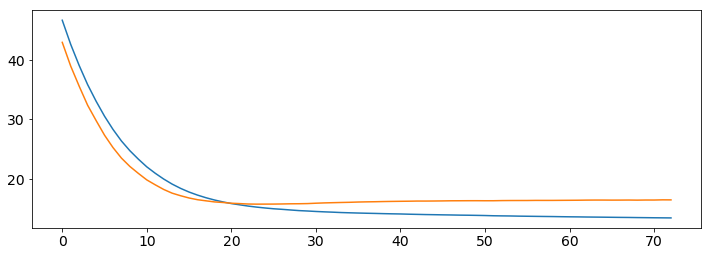

In [435]:
# plot out the eval_metric over the n_estimators
plt.plot(xgb_regr_results['validation_0']['rmse'])
plt.plot(xgb_regr_results['validation_1']['rmse'])

RMSE: 15.212043292478642


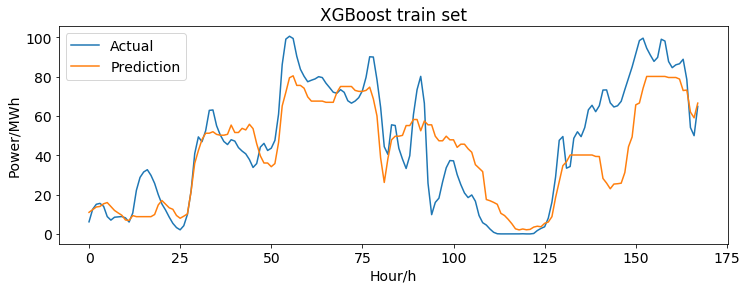

In [436]:
print('RMSE: '+str(mse(y_train, xgb_regr.predict(Xs_train),squared=False)))
plt.plot(y_train[:168],label='Actual')
plt.plot(xgb_regr.predict(Xs_train)[:168],label='Prediction')
plt.xlabel('Hour/h')
plt.ylabel('Power/MWh')
plt.title('XGBoost train set')
plt.legend()
plt.show()

RMSE: 15.711731685986926


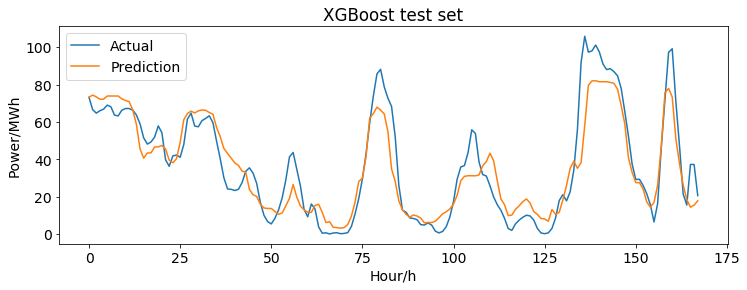

In [437]:
print('RMSE: '+str(mse(y_test, xgb_regr.predict(Xs_test),squared=False)))
plt.plot(y_test[:168],label='Actual')
plt.plot(xgb_regr.predict(Xs_test)[:168],label='Prediction')
plt.xlabel('Hour/h')
plt.ylabel('Power/MWh')
plt.title('XGBoost test set')
plt.legend()

In [438]:
xgbcoef = pd.DataFrame({'feature':X.columns, 
                        'importance': xgb_regr.feature_importances_*100})

In [440]:
xgbcoef[xgbcoef.importance>0].sort_values(by='importance',ascending=False).head(20).T

,4,5,6,2,8,64,7,0,75,9,3,11,22,10,74,63,26,27,20,28
feature,windGust,windGust2,windGust3,windSin,windSpeed2,dayofmonth_23,windSpeed,humidity,dayofmonth_5,windSpeed3,windCos,hour_1,hour_2,hour_0,dayofmonth_4,dayofmonth_22,hour_23,hour_3,hour_18,hour_4
importance,27.5896,23.732,13.9557,2.24483,2.03067,1.73651,1.51421,1.29193,1.14387,1.10149,0.883927,0.793619,0.768265,0.736286,0.735514,0.734354,0.693915,0.665227,0.663082,0.608371


### Weather reforecast LSTM
Unlike a time series model that utilizes past weather and power data to predict future, in a regression model structured like the one shown above, future weather data is required to predict future power. Future weather can be obtained through a weather forecast service, but in this case, the model is trained on actual weather provided by Dark Sky instead, and historical forecast data is considerably harder to obtain. A solution would be to use the past data to retroactively forecast (reforecast) the weather. The reforecast weather data can then be used to train the model and make a forecast. 

A significant advantage of this approach is that it is possbile to get localized and wind forecast this way. Wind can be a highly localized phenomenon that easily affect by local terrain. Also wind turbines are 50-100 m high up in the sky, where the wind speed is different than that of the surface wind. It's believed the realive low scoring of the XGBoost model is partilly due to the low spital resolution of the weather data. It's unlikely any weather service will provide precise forecast at the the exact location and attidude of the wind farm. Instead, wind farms can use the local wind meter to measure and forecast wind specific for the farm, which can be then used to predict power.

The following two sections serve as a proof of concept for this approach. This should be the most promoising wind power prediction model should such model is put into real world production. 

Weather forecast time series is a realtively well-documented field in machine learning. In consideration of the medium- or even long-term forecast capacitiy of the model, LSTM model is once again choosen. Previous LSTM model code can be modified for weather reforecast. Each of the six features (`humidity`, `density`, `windSin`, `windCos`, `windGust`, `windSpeed`,) are modeled seperately. Here, to save space, only the code for modelling `windSpeed` is shown, other features are modelled use the same method with minimal tweaking. The final models are all saved in the models folder as .h5 files.

In [25]:
df = pd.read_csv('./datasets/Processed'+farm+'.csv')

In [26]:
def create_dataset(X, time_steps): 
    '''
    Define a helper function to create 3D data with in the shape of [samples, time_steps, features] for LSTM
    '''
    X = pd.DataFrame(X)
    Xs,ys = [],[]
    for i in range(len(X) - time_steps-pred_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(X.iloc[i+time_steps:i+time_steps+pred_steps].astype('float64').values)
    return np.array(Xs), np.asarray(ys)

In [27]:
data = df[['windSpeed']]
time_steps = 4
pred_steps = 24

In [28]:
from sklearn.preprocessing import RobustScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Bidirectional, LSTM, Dropout, Input, GRU 
from sklearn.metrics import mean_squared_error as mse

In [29]:
# Split to train & test while keeping the order of the series
train_size = int(len(data) * 0.9)
test_size = len(data) - train_size
train, test = data.iloc[0:train_size], data.iloc[train_size:len(df)]

scaler=RobustScaler()
trains = scaler.fit_transform(train)
tests = scaler.transform(test)
alls = scaler.transform(data)

X_train, y_train = create_dataset(trains,time_steps)
X_test, y_test = create_dataset(tests,time_steps)
X_all, y_all = create_dataset(alls,time_steps)

In [30]:
inputs=Input(shape=(X_train.shape[1], X_train.shape[2]))
x=Bidirectional(LSTM(96,return_sequences=False,activation='relu'))(inputs)
x=Dropout(0.01)(x)
outputs=(Dense(pred_steps,activation='linear'))(x)
speed=Model(inputs=inputs, outputs=outputs)

In [31]:
%%time
earlyStop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
reduceLR = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001, verbose=0)
earlyStop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
speed.compile(loss='mse', optimizer=tf.optimizers.Nadam(learning_rate=0.01))
history = speed.fit(X_train, y_train, epochs=150, callbacks=[earlyStop,reduceLR],
                    batch_size=32, validation_split=0.1, shuffle=False,verbose=0)

CPU times: user 2min 38s, sys: 13.8 s, total: 2min 52s
Wall time: 1min 44s


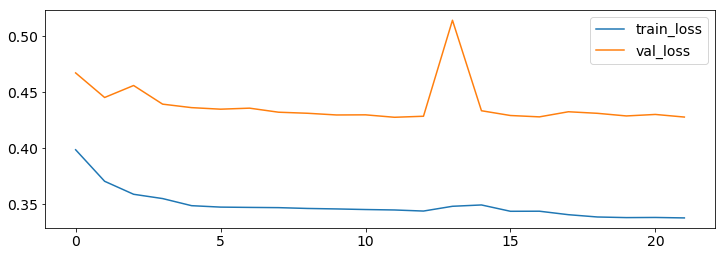

In [32]:
# Plot out the loss values over epoch
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

In [33]:
y_pred_steps = 1 # Show which ys in the multiple step we're going to use

y_test_pred = speed.predict(X_test)

y_test_list = []
for i in y_test.reshape(y_test.shape[0], pred_steps):
    y_test_list.append(i[y_pred_steps-1]) # take only the y_pred_steps-th item in y_test

y_test_pred_list = []
for i in y_test_pred.reshape(y_test_pred.shape[0], pred_steps):
    y_test_pred_list.append(i[y_pred_steps-1]) # take only the y_pred_steps-th item in y_test

y_test_inv = scaler.inverse_transform(np.array(y_test_list).reshape(1,-1))
y_test_pred_inv = scaler.inverse_transform(np.array(y_test_pred_list).reshape(1, -1))

speed1_pred = pd.DataFrame()
shift = y_pred_steps-1
if y_pred_steps == 1:
    speed1_pred['actual'] = y_test_inv.reshape(y_test_inv.shape[1], )
    speed1_pred['prediction'] = y_test_pred_inv.reshape(y_test_pred_inv.shape[1], )
else:
    speed1_pred['actual'] = y_test_inv.reshape(y_test_inv.shape[1], )[:-shift]
    speed1_pred['prediction'] = y_test_pred_inv.reshape(y_test_pred_inv.shape[1], )[shift:]

In [34]:
y_pred_steps = 24 # Show which ys in the multiple step we're going to use

y_test_pred = speed.predict(X_test)

y_test_list = []
for i in y_test.reshape(y_test.shape[0], pred_steps):
    y_test_list.append(i[y_pred_steps-1]) # take only the y_pred_steps-th item in y_test

y_test_pred_list = []
for i in y_test_pred.reshape(y_test_pred.shape[0], pred_steps):
    y_test_pred_list.append(i[y_pred_steps-1]) # take only the y_pred_steps-th item in y_test

y_test_inv = scaler.inverse_transform(np.array(y_test_list).reshape(1,-1))
y_test_pred_inv = scaler.inverse_transform(np.array(y_test_pred_list).reshape(1, -1))

speed24_pred = pd.DataFrame()
shift = y_pred_steps-1
if y_pred_steps == 1:
    speed24_pred['actual'] = y_test_inv.reshape(y_test_inv.shape[1], )
    speed24_pred['prediction'] = y_test_pred_inv.reshape(y_test_pred_inv.shape[1], )
else:
    speed24_pred['actual'] = y_test_inv.reshape(y_test_inv.shape[1], )[:-shift]
    speed24_pred['prediction'] = y_test_pred_inv.reshape(y_test_pred_inv.shape[1], )[shift:]

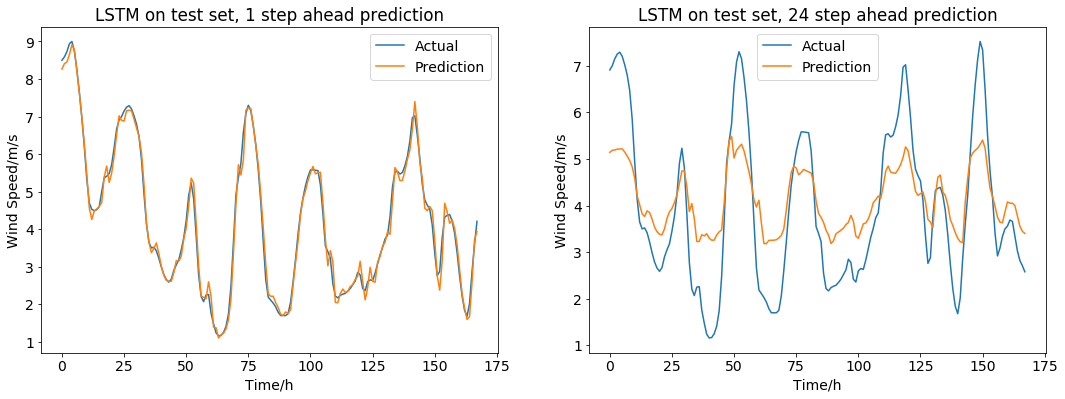

In [45]:
plt.figure(figsize=(18,6))
plt.subplot(121)
plt.plot(speed1_pred['actual'][:168],label='Actual')
plt.plot(speed1_pred['prediction'][:168],label='Prediction')
plt.ylabel("Wind Speed/m/s")
plt.xlabel("Time/h")
plt.title("LSTM on test set, 1 step ahead prediction")
plt.legend()

plt.subplot(122)
plt.plot(speed24_pred['actual'][:168],label='Actual')
plt.plot(speed24_pred['prediction'][:168],label='Prediction')
plt.ylabel("Wind Speed/m/s")
plt.xlabel("Time/h")
plt.title("LSTM on test set, 24 step ahead prediction")
plt.legend();

In [18]:
# predict all ys, put the 1 step ahead result in a speedRF in the original df 
y_all_pred = speed.predict(X_all)

y_all_pred_list = []
for i in y_all_pred.reshape(y_all_pred.shape[0], pred_steps):
    y_all_pred_list.append(i[0]) 
y_all_pred_inv = scaler.inverse_transform(np.array(y_all_pred_list).reshape(1, -1))
y_pred = y_all_pred_inv.reshape(y_all_pred_inv.shape[1],)

df['speedRF'] = [np.nan]*(time_steps) + y_pred.tolist() + [np.nan]*(pred_steps)

In [21]:
# df.to_csv('./datasets/rf_'+farm+'.csv',index=False)
# speed.save('./models/speed_'+farm+'.h5')

LSTM performs well on 1 step ahead prediction. For the 24 step ahead prediction, the model can still perform well in terms of identifying the seasonality, but not the magnitude. This will cause a degrade in performance over time and should be taken into consideration in production or to further tweak the model.

### XGBoost on reforecast data

In [321]:
df = pd.read_csv('./predictions/'+farm+'.csv')

In [322]:
cA1, cD1 = pywt.dwt(df.power, 'db4')
A1 = pywt.idwt(cA1,None, 'db4')
D1 = pywt.idwt(None,cD1, 'db4')
df['power'] = A1[:len(df)]
df.loc[df[df['power'] < 0].index,'power'] = 0

In [323]:
df['speedRF2'] = df['speedRF']**2
df['speedRF3'] = df['speedRF']**3
df['gustRF2'] = df['gustRF']**2
df['gustRF3'] = df['gustRF']**3

In [324]:
df.dropna(inplace=True)
df.reset_index(drop=True,inplace=True)

In [325]:
df.time = pd.to_datetime(df.time,dayfirst=True)
df['hour'] = df['time'].dt.hour
df['month'] = df['time'].dt.month
df['year'] = df['time'].dt.year
df['dayofmonth'] = df['time'].dt.day

In [326]:
cat_col = ['hour', 'month', 'year', 'dayofmonth']
num_col = ['speedRF', 'gustRF', 'huminityRF', 'densityRF', 'sinRF',
       'cosRF', 'speedRF2', 'speedRF3', 'gustRF2', 'gustRF3']

for s in cat_col:
    df[s] = df[s].apply(str)

X = pd.concat([df[num_col],pd.get_dummies(df[cat_col])],axis=1)
y = df['power']

In [327]:
X.head(2)

,speedRF,gustRF,huminityRF,densityRF,sinRF,cosRF,speedRF2,speedRF3,gustRF2,gustRF3,...,dayofmonth_29,dayofmonth_3,dayofmonth_30,dayofmonth_31,dayofmonth_4,dayofmonth_5,dayofmonth_6,dayofmonth_7,dayofmonth_8,dayofmonth_9
0,3.806134,4.429570,0.765086,1.248463,-0.326563,-0.908547,14.486654,55.138143,19.621092,86.913005,...,0,0,0,0,1,0,0,0,0,0
1,2.994609,4.452823,0.836361,1.253753,-0.340553,-0.914671,8.967682,26.854701,19.827634,88.288948,...,0,0,0,0,1,0,0,0,0,0


In [328]:
train_size = int(len(df) * 0.9)
test_size = len(df) - train_size
X_train, X_test = X.iloc[0:train_size], X.iloc[train_size:len(df)]
y_train, y_test = y.iloc[0:train_size].values, y.iloc[train_size:len(df)].values

In [329]:
ss = RobustScaler()
Xs_train = ss.fit_transform(X_train)
Xs_test = ss.transform(X_test)

In [330]:
eval_set = [(Xs_train, y_train), (Xs_test, y_test)]

In [355]:
xgb_rf=xgb.XGBRegressor(reg_alpha=0.1, reg_lambda=1, colsample_bytree=0.7, learning_rate=0.100, gamma=0.1, n_estimators=500,
              max_depth=5, min_child_weight=3)

In [356]:
xgb_rf.fit(Xs_train, y_train, eval_metric ='rmse',eval_set=eval_set,verbose=False,early_stopping_rounds=50);

In [357]:
results = xgb_rf.evals_result()

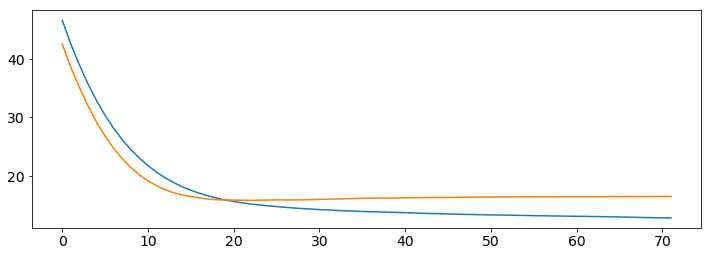

In [358]:
plt.plot(results['validation_0']['rmse'])
plt.plot(results['validation_1']['rmse'])

RMSE: 15.21488931509488


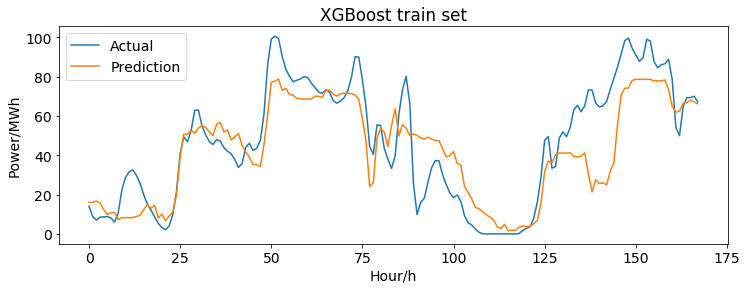

In [359]:
print('RMSE: '+str(mse(y_train, xgb_rf.predict(Xs_train),squared=False)))
plt.plot(y_train[:168],label='Actual')
plt.plot(xgb_rf.predict(Xs_train)[:168],label='Prediction')
plt.xlabel('Hour/h')
plt.ylabel('Power/MWh')
plt.title('XGBoost train set')
plt.legend()
plt.show()

RMSE: 15.849023954534205


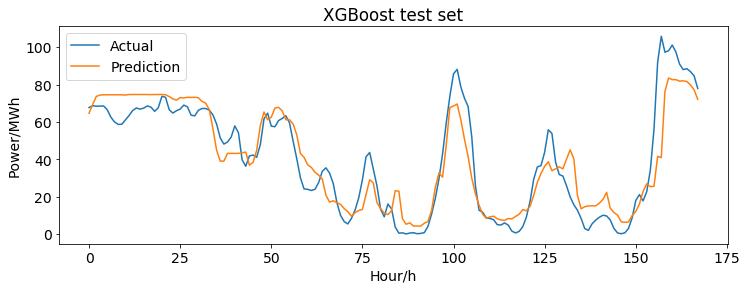

In [360]:
print('RMSE: '+str(mse(y_test, xgb_rf.predict(Xs_test),squared=False)))
plt.plot(y_test[:168],label='Actual')
plt.plot(xgb_rf.predict(Xs_test)[:168],label='Prediction')
plt.xlabel('Hour/h')
plt.ylabel('Power/MWh')
plt.title('XGBoost test set')
plt.legend()

In [361]:
xgbcoef_rf = pd.DataFrame({'feature':X.columns, 
                        'importance': xgb_rf.feature_importances_*100})

In [445]:
xgbcoef_rf[xgbcoef_rf.importance>0].sort_values(by='importance',ascending=False).head(20).T

,9,8,1,6,64,4,0,10,11,27,72,22,14,26,5,13,15,63,20,17
feature,gustRF3,gustRF2,gustRF,speedRF2,dayofmonth_23,sinRF,speedRF,hour_0,hour_1,hour_3,dayofmonth_30,hour_2,hour_12,hour_23,cosRF,hour_11,hour_13,dayofmonth_22,hour_18,hour_15
importance,29.151,17.0914,16.0601,3.05206,1.92458,1.45601,1.28427,0.833428,0.807356,0.750527,0.739369,0.694287,0.687229,0.683009,0.65953,0.65094,0.650541,0.644173,0.629874,0.620672


The XGBoost model with reforecast weather data performs similarly to that with historic weather data. However this is only using the 1 step ahead reforecast data, performance can degrade over time.

# Summary
The forecast for wind power can be regarded as both a time series problem and a regression problem. As a time series, the random walk nature of the power data proves to be difficult to build a model that's significantly better than a persistent model. Furthermore, the medium-term forecast performance is poor because it fails to learn the long-term trend. 

As a regression problem, weather data is mapped directly to the power output. An XGBoost regression model for this mapping process does not have a performance degrading issue for the medium-term forecast in itself, but the accuracy of the model relies heavily on the quality of weather forecast, which is subject to degradation.

A weather reforecast approach can address the low temporal- and spatial-resolution issue with regular weather services. Hopefully with localized weather data forecast performance will be improved. In production, this can also be scaled to each wind turbine instead of the whole farm, taking into consideration the working condition of each turbine.

# Final thoughts

This project is only a first step towards a complex forecast problem, and a lot more improvement can be done. Some further works to consider include:

- Due to time constraints, the models are yet to be fine-tuned. The LSTM models, in particular, suffer from some overfitting or underfitting issue. Also to improve their medium-term forecast performance, perhaps a different architecture, like a combination of CNN and LSTM, is needed.

- Both time series and regression models have their advantages and trade-offs, perhaps an ensemble of the models can show better overall performance.

- The reforecast approach cannot forecast a sudden change in weather conditions. Weather services are still a valuable information source for these sudden changes and should be taken into consideration.

- The higher power values of speed and gust are highly correlated among themselves, perhaps further feature selection is beneficial.

- Often times, knowing the uncertainty of the forecast is just as important as the forecast itself. Quantile regression with XGBoost or probabilistic regression with Tensorflow Probability can be considered to make probabilistic forecast.